<a href="https://colab.research.google.com/github/md-hexdrive/Self-Driving-AI-Car-Project/blob/master/Self-Driving-AI-Car-Project/training/Train_my_AI_based_on_DeepPiCar_AI_lane_following_example_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Lane Navigation via Nvidia Model
Original Author: David Tian

Date: 2020-02-12

This code is described in the [DeepPiCar - Part 5: Autonomous Lane Navigation via Deep Learning](https://medium.com/@dctian/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110?source=your_stories_page---------------------------) Blog.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
"""
try:
#  %tensorflow_version 2.x
except Exception:
  pass
"""
import tensorflow as tf

In [0]:
#Mount personal Google Drive, will ask for authentication code.
from google.colab import drive
import os
import os.path
drive.mount('/content/gdrive')
model_name = 'Final-Driving-Model'
model_output_dir = '/content/gdrive/My Drive/Self-Driving-Car-Project/models/' + model_name
if not os.path.exists(model_output_dir):
  os.makedirs(model_output_dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2)  Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
  # store gmail password in my google drive (not the most secure way)
  # but it is much safer than storing it directly in this notebook,
  # and upload it to github for everyone to see
  with open('/content/gdrive/My Drive/Colab Notebooks/pw.txt') as file:
    data = file.readlines()
  
  gmail_user = 'pdotzert7@gmail.com'
  gmail_password = data[0]

  sent_from = gmail_user
  to = ['pcdotzert@gmail.com']
  subject = msg
  body = '%s\n\n- David' % msg

  email_text = \
  """From: %s
  To: %s
  Subject: %s

  %s
  """ % (sent_from, ", ".join(to), subject, body)

  server = smtplib.SMTP("smtp.gmail.com", 587)
  server.ehlo()
  server.starttls()
  server.login(gmail_user, gmail_password)
  server.sendmail(sent_from, to, email_text)
  server.quit()

  print(f'Email: \n{email_text}')

In [0]:
#imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', ':,.4f'.format)
pd.set_option('display.max_colwidth', 200)

#tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print(f'tf.__version__: {tf.__version__}')
print(f'keras.__version__: {keras.__version__}')

#sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 1.15.0
keras.__version__: 2.2.4-tf


image_path: /content/gdrive/My Drive/Self-Driving-Car-Project/recordings/Final-Driving-Record-Set/image_108_200226_162558_1.jpg
steering_angle 1


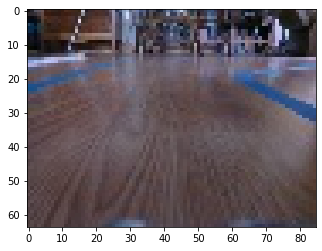

In [0]:
#import images
#!cd /content
#!git clone https://github.com/dctian/DeepPiCar

#!ls

data_dir = '/content/gdrive/My Drive/Self-Driving-Car-Project/recordings/Final-Driving-Record-Set'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = '*.jpg'
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir, filename))
    try:
      angle = int(filename[-5])
      
    except ValueError:
      angle = int(filename[-6])
    
    steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_angle %i" % steering_angles[image_index])

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([304.0000, 0.0000, 0.0000, 0.0000, 921.0000, 0.0000, 0.0000,
        59.0000]),
 array([1.0000, 1.2500, 1.5000, 1.7500, 2.0000, 2.2500, 2.5000, 2.7500,
        3.0000]),
 <a list of 8 Patch objects>)

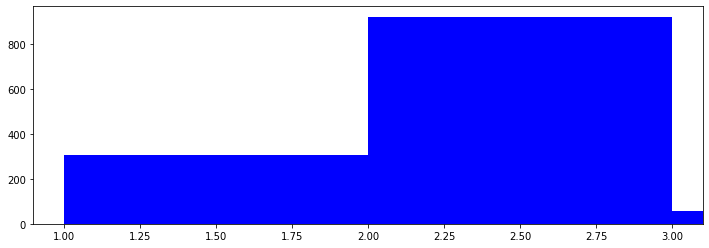

In [0]:
# Look at the distribution of the steering angle
num_of_bins = 8
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 1027
 Validation data: 257


Text(0.5, 1.0, 'Validation data')

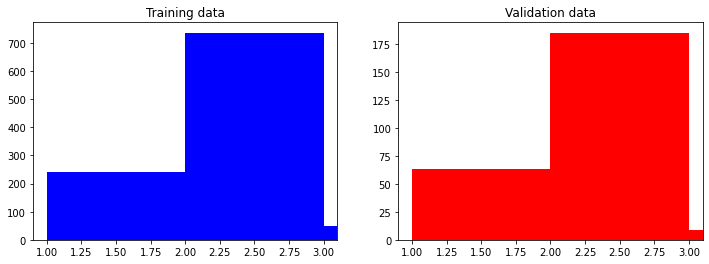

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2)
print('Training data: %d\n Validation data: %d' % (len(x_train), len(x_valid)))

#plot distributions of train and valid data to ensure consistency
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation data')

# Augment Images

Text(0.5, 1.0, 'zoomed')

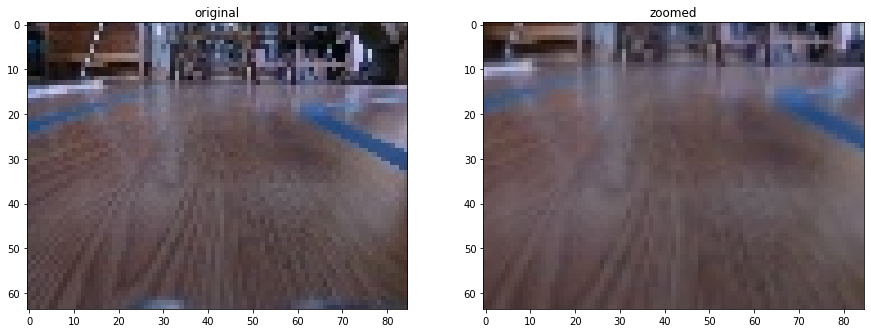

In [0]:
def my_imread(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def zoom(image):
  zoom = img_aug.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

fig, axes = plt.subplots(1,2, figsize=(15,10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

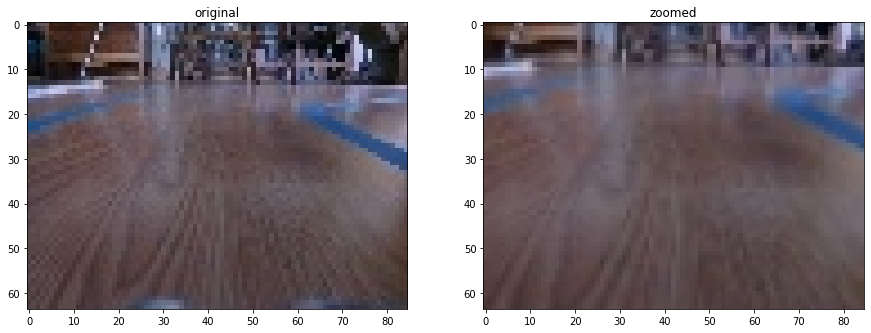

In [0]:
def compare_images(text1 = 'original', text2 = 'modified', modifier_function = my_imread, image1 = my_imread(image_paths[image_index])):
  fig, axes = plt.subplots(1,2, figsize=(15,10))
  image_orig = image1
  image_modified = modifier_function(image_orig)
  axes[0].imshow(image_orig)
  axes[0].set_title(text1)
  axes[1].imshow(image_modified)
  axes[1].set_title(text2)

compare_images('original', 'zoomed', zoom)

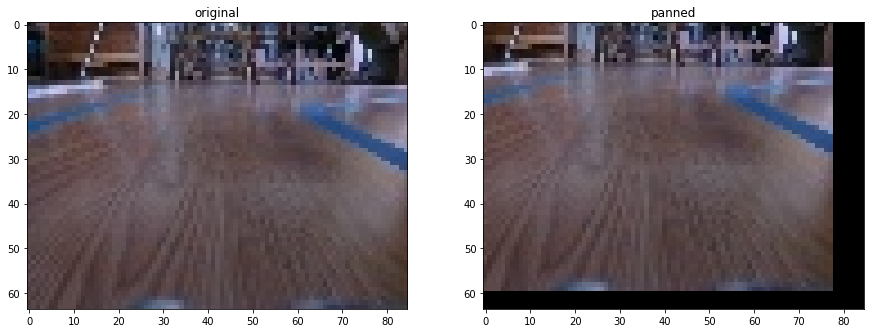

In [0]:
def pan(image):
  # pan left / right / up / down, about 10%
  pan = img_aug.Affine(translate_percent= {'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

compare_images('original', 'panned', pan)

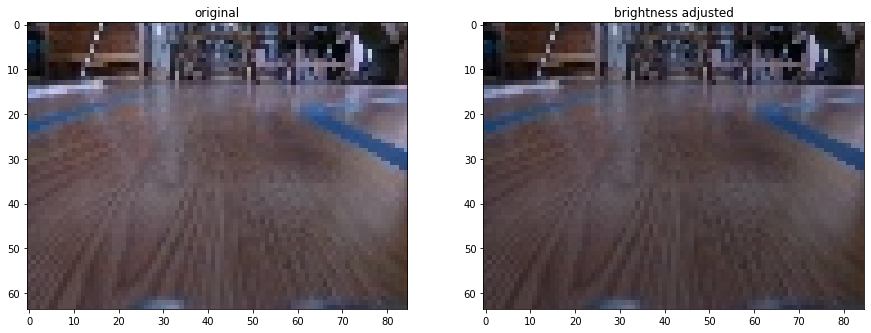

In [0]:
def adjust_brightness(image):
  # increase or decrease brightness by 30%
  brightness = img_aug.Multiply((0.7, 1.3))
  image = brightness.augment_image(image)
  return image

compare_images('original', 'brightness adjusted', adjust_brightness)

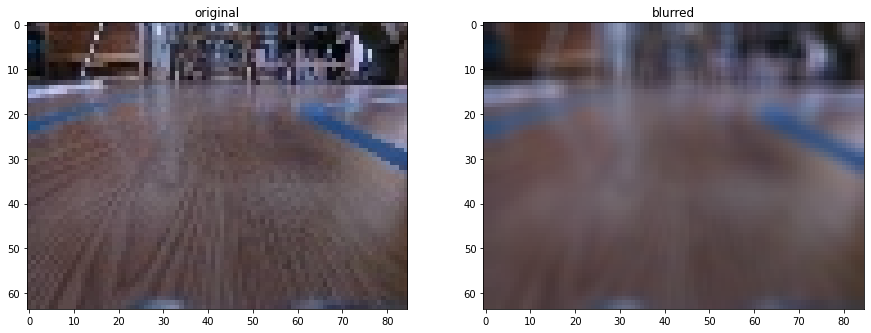

In [0]:
def blur(image):
  kernel_size = random.randint(1, 5) # kernel largeer than 5 would make the image way to blurry
  image = cv2.blur(image,(kernel_size, kernel_size))
  return image

compare_images('original', 'blurred', blur)

Text(0.5, 1.0, 'flipped, angle=1')

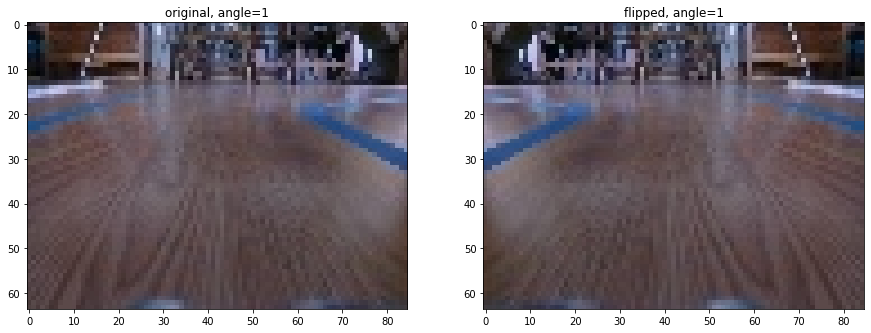

In [0]:
def random_flip(image, steering_angle):
  is_flip = random.randint(0, 1)
  if is_flip == 1:
    # randomly flip horizon
    image = cv2.flip(image,1)
    if (not steering_angle == 3):
      steering_angle = 2 - steering_angle
  
  return image, steering_angle

fig, axes = plt.subplots(1,2, figsize=(15,10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title('original, angle=%s' % (steering_angles[image_index]))
axes[1].imshow(image_flip)
axes[1].set_title('flipped, angle=%s' % steering_angle)


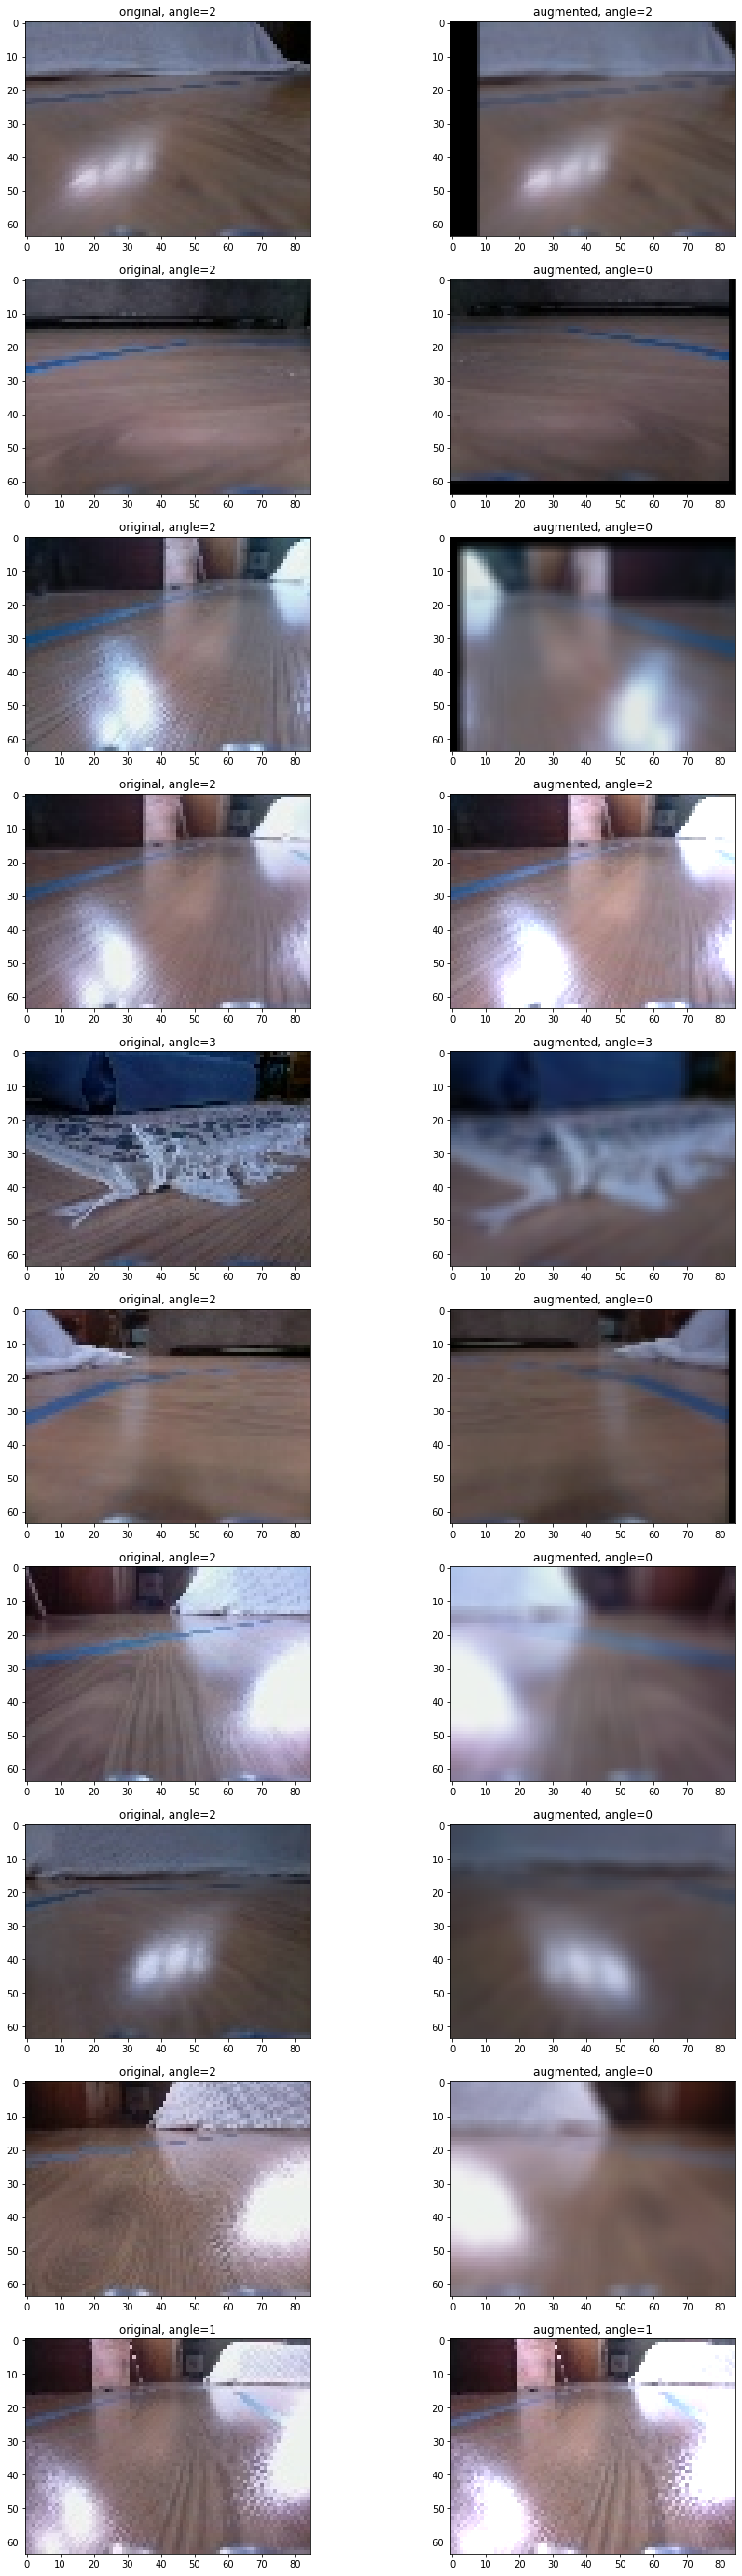

In [0]:
# put it together
def random_augment(image, steering_angle):
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = blur(image)
  if np.random.rand() < 0.5:
    image = adjust_brightness(image)
  image, steering_angle = random_flip(image, steering_angle)

  return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
  rand_index = random.randint(0, len(image_paths) - 1)
  image_path = image_paths[rand_index]
  steering_angle_orig = steering_angles[rand_index]

  image_orig = my_imread(image_path)
  image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)

  axes[i][0].imshow(image_orig)
  axes[i][0].set_title('original, angle=%s' % steering_angle_orig)
  axes[i][1].imshow(image_aug)
  axes[i][1].set_title('augmented, angle=%s' % steering_angle_aug)

# Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

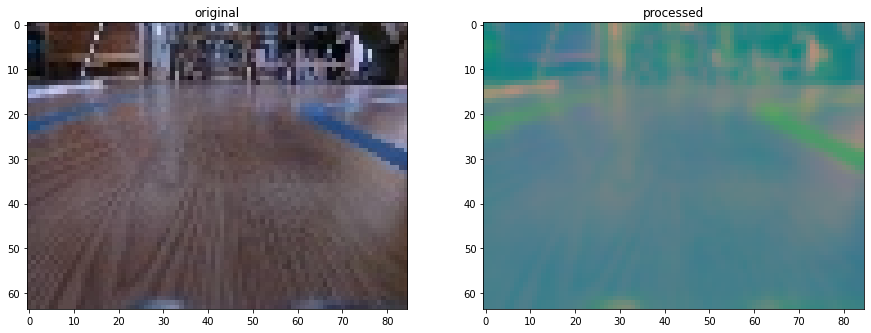

In [0]:
def img_preprocess(image):
  height, _, _ = image.shape
  #image = image[int(height/2):,:,:] # remove top half of the image, as it is not relavant for lane following
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # Nvidia model said it best to use YUV color space
  image = cv2.GaussianBlur(image, (3,3), 0)
  image = cv2.resize(image, (85,64)) # input image size(200,66) Nvidia model
  image = image / 255 # normalizing, the processed image becomes black for some reason. Do we need this?
  return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title('original')
axes[1].imshow(image_processed)
axes[1].set_title('processed')

# Create and Train Model

In [0]:
# Experiment with smaller and hopefully faster models
def smaller_model():
  model = Sequential([
                      Conv2D(12, (5,5), input_shape=(64, 85, 3), activation='elu'),
                      Conv2D(5, (5,5), activation='elu'),
                      Flatten(),
                      Dropout(0.2),
                      Dense(10, activation='elu'),
                      Dense(4, activation='softmax')
  ], name="Smaller Model")

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
def nvidia_model():

  # elu=Exponential Linear Unit, similar to leaky Relu
  # skipping 1st hidden layer (normalization layer), as we have normalized the data

  model = Sequential([
    # Convolution Layers
    Conv2D(24, (5, 5), strides=(2,2), input_shape=(64, 85, 3), activation='elu'),
    Conv2D(36, (5, 5), strides=(2,2), activation='elu'),
    Conv2D(48, (5, 5), strides=(2,2), activation='elu'),
    Conv2D(64, (3, 3), activation='elu'),
    Dropout(0.2), # not in original model. added for more robustness
    Conv2D(64, (3, 3), activation='elu'),

    # Fully Connected Layers
    Flatten(),
    Dropout(0.2), # not in original model. added for more robustness
    Dense(100, activation='elu'),
    Dense(50, activation='elu'),
    Dense(10, activation='elu'),

    # output layer: movement commands: go forward-left, forward-straight, forward-right, + stop
    Dense(4, activation='softmax')
  ], name='Nvidia_Model')

  # since this is a regression problem not classification problem,
  # we use MSE (Mean Squared Error) as loss function
  optimizer = Adam()#lr=1e-3) # lr is learning rate
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


In [0]:
model = nvidia_model()
print(model.summary())
# check that we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 41, 24)        1824      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 19, 36)        21636     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 8, 48)          43248     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 6, 64)          27712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)              

In [0]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
  while True:
    batch_images = []
    batch_steering_angles = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      image_path = image_paths[random_index]
      image = my_imread(image_paths[random_index])
      steering_angle = steering_angles[random_index]
      if is_training:
        # training: augment image
        image, steering_angle = random_augment(image, steering_angle)
      
      image = img_preprocess(image)
      batch_images.append(image)
      batch_steering_angles.append(steering_angle)
    
    yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

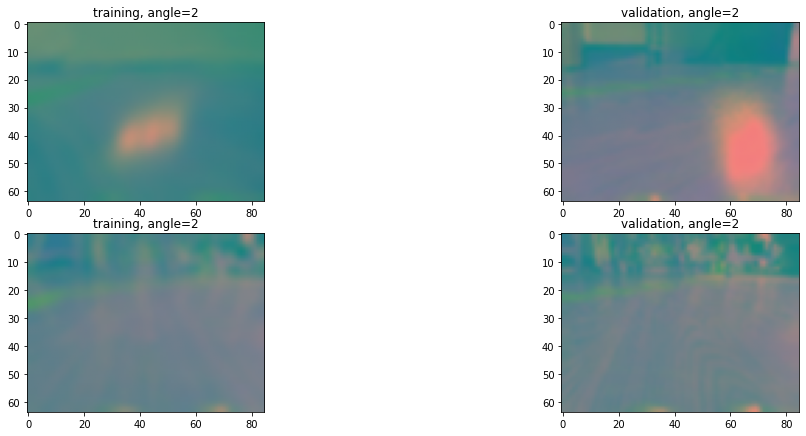

In [0]:
ncol = 2
nrow = 2

x_train_batch, y_train_batch = next(image_data_generator(x_train, y_train, nrow, True))
x_valid_batch, y_valid_batch = next(image_data_generator(x_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
  axes[i][0].imshow(x_train_batch[i])
  axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
  axes[i][1].imshow(x_valid_batch[i])
  axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [0]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [0]:
# this block prevents the training from starting if we tell Colab to Run All
# it works by throwing an error when Colab reaches this code cell, 
# preventing the code below from being run automatically
DO_NOT_RUN_ALL

NameError: ignored

In [0]:
# save the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, model_name + '_check.h5'))

#SendEmail('lane nav train started')
history = model.fit(image_data_generator(x_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=30,
                              epochs=25,
                              validation_data = image_data_generator(x_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=20,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir, model_name + '_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

#SendEmail('lane nav train finished. val_loss from %.1f to %.1f' % (history.history['val_loss'][0], history.history['val_loss'][-1]))

Epoch 1/25
30/30 [==============================] - 401s 13s/step - loss: 1.1916 - acc: 0.4160 - val_loss: 1.0321 - val_acc: 0.4890
Epoch 2/25
30/30 [==============================] - 34s 1s/step - loss: 0.9346 - acc: 0.6330 - val_loss: 0.6292 - val_acc: 0.8655
Epoch 3/25
30/30 [==============================] - 33s 1s/step - loss: 0.7080 - acc: 0.7483 - val_loss: 0.3869 - val_acc: 0.9010
Epoch 4/25
30/30 [==============================] - 32s 1s/step - loss: 0.5738 - acc: 0.8063 - val_loss: 0.3152 - val_acc: 0.9085
Epoch 5/25
30/30 [==============================] - 33s 1s/step - loss: 0.4575 - acc: 0.8477 - val_loss: 0.2222 - val_acc: 0.9130
Epoch 6/25
30/30 [==============================] - 32s 1s/step - loss: 0.4180 - acc: 0.8673 - val_loss: 0.1715 - val_acc: 0.9500
Epoch 7/25
30/30 [==============================] - 32s 1s/step - loss: 0.3812 - acc: 0.8760 - val_loss: 0.1385 - val_acc: 0.9575
Epoch 8/25
30/30 [==============================] - 33s 1s/step - loss: 0.3069 - acc: 0.

In [0]:
history.history

{'acc': [0.416,
  0.633,
  0.74833333,
  0.80633336,
  0.8476667,
  0.86733335,
  0.876,
  0.895,
  0.9023333,
  0.91433334,
  0.918,
  0.9253333,
  0.921,
  0.92966664,
  0.941,
  0.948,
  0.937,
  0.9446667,
  0.9493333,
  0.95266664,
  0.95066667,
  0.95133334,
  0.95533335,
  0.95266664,
  0.96],
 'loss': [1.191558410724004,
  0.9346053898334503,
  0.7080285390218098,
  0.5738074084122976,
  0.45747772653897606,
  0.417971999446551,
  0.3812392140428225,
  0.30692868332068124,
  0.285461317996184,
  0.25659968505303066,
  0.2136570965250333,
  0.22428854405879975,
  0.243220587571462,
  0.1973960610727469,
  0.17132751817504566,
  0.14969909402231377,
  0.18725332841277123,
  0.1553333666175604,
  0.14017214899261793,
  0.1456689640879631,
  0.14214506261050702,
  0.13538981477419534,
  0.12313003192345301,
  0.1269945780436198,
  0.10772492413719495],
 'val_acc': [0.489,
  0.8655,
  0.901,
  0.9085,
  0.913,
  0.95,
  0.9575,
  0.966,
  0.972,
  0.967,
  0.959,
  0.9615,
  0.971,


In [0]:
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir, model_name + '_final.h5'))
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)



In [0]:
# plot training a validation losses
# this should be the same as tensorboard
#history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
  history = pickle.load(f)

In [0]:
history

{'acc': [0.416,
  0.633,
  0.74833333,
  0.80633336,
  0.8476667,
  0.86733335,
  0.876,
  0.895,
  0.9023333,
  0.91433334,
  0.918,
  0.9253333,
  0.921,
  0.92966664,
  0.941,
  0.948,
  0.937,
  0.9446667,
  0.9493333,
  0.95266664,
  0.95066667,
  0.95133334,
  0.95533335,
  0.95266664,
  0.96],
 'loss': [1.191558410724004,
  0.9346053898334503,
  0.7080285390218098,
  0.5738074084122976,
  0.45747772653897606,
  0.417971999446551,
  0.3812392140428225,
  0.30692868332068124,
  0.285461317996184,
  0.25659968505303066,
  0.2136570965250333,
  0.22428854405879975,
  0.243220587571462,
  0.1973960610727469,
  0.17132751817504566,
  0.14969909402231377,
  0.18725332841277123,
  0.1553333666175604,
  0.14017214899261793,
  0.1456689640879631,
  0.14214506261050702,
  0.13538981477419534,
  0.12313003192345301,
  0.1269945780436198,
  0.10772492413719495],
 'val_acc': [0.489,
  0.8655,
  0.901,
  0.9085,
  0.913,
  0.95,
  0.9575,
  0.966,
  0.972,
  0.967,
  0.959,
  0.9615,
  0.971,


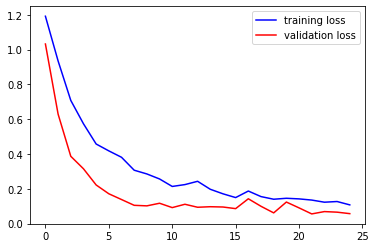

In [0]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(['training loss', 'validation loss'])

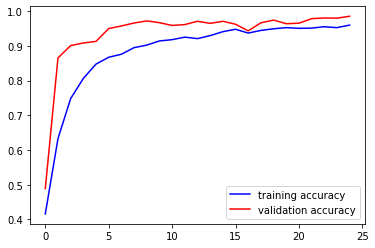

In [0]:
history
plt.plot(history['acc'], color='blue')
plt.plot(history['val_acc'], color='red')
plt.legend(['training accuracy', 'validation accuracy'])

2
[2]


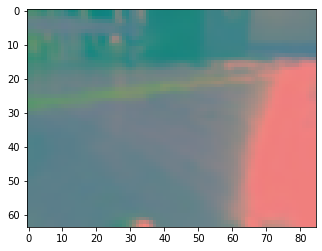

In [0]:
model = load_model(f'{model_output_dir}/{model_name}_final.h5')
x_test, y_test = next(image_data_generator(image_paths, steering_angles, 1, False))
y_pred = np.argmax(model.predict(x_test))
print(y_pred)
print(y_test)

plt.imshow(x_test[0])

In [0]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(y_true, y_pred):

  mse = mean_squared_error(y_true, y_pred)
  r_squared = r2_score(y_true, y_pred)

  print(f'mse       = {mse:.2}')
  print(f'r_squared = {r_squared:.2%}')
  print()

def predict_and_summarize(x, y):
  model = load_model(f'{model_output_dir}/{model_name}_check.h5')
  y_pred = np.asarray([np.argmax(model.predict(x))])
  summarize_prediction(y, y_pred)
  return y_pred

mse       = 0.0
r_squared = nan%



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


IndexError: ignored

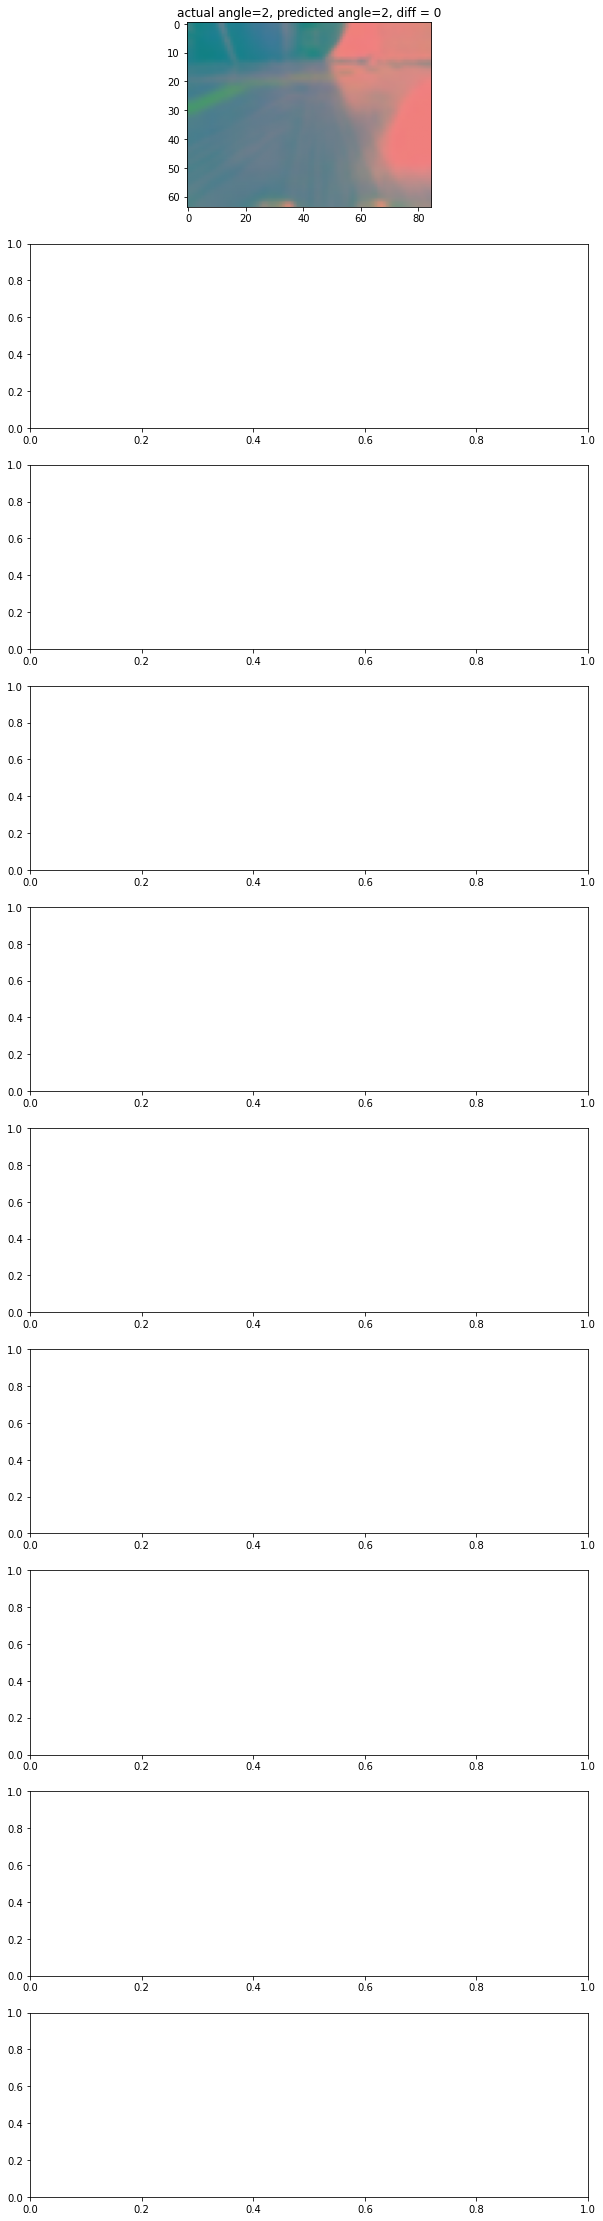

In [0]:
n_tests = 1
x_test, y_test = next(image_data_generator(x_valid, y_valid, 1, False))

y_pred = predict_and_summarize(x_test, y_test)

n_tests_show = 10
fix, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
  axes[i].imshow(x_test[i])
  axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")